# Final Project TSP

In [1]:
import re

fin = open("weight42.out", "rt")
fout = open("weight42rev.out", "wt")

for line in fin:
	fout.write(re.sub(' +',' ',line))
	
fin.close()
fout.close()

In [2]:
import optparse
import sys
import yaml
import math
from random import Random
import re
import numpy as np
import matplotlib.pyplot as plt

class EV3_Config:
    """
    EV3 configuration class
    """
    # class variables
    sectionName='EV3'
    options={'populationSize': (int,True),
             'generationCount': (int,True),
             'randomSeed': (int,True),
             'crossoverFraction': (float,True),
             'minLimit': (float,True),
             'maxLimit': (float,True),
             'startCity':(int,True),
             'learningRate':(float,True),
            'cityCoordinat':(str,True),
            'weightData':(str,True)
            }
     
    #constructor
    def __init__(self, inFileName):
        #read YAML config and get EV3 section
        infile=open(inFileName,'r')
        ymlcfg=yaml.safe_load(infile)
        infile.close()
        eccfg=ymlcfg.get(self.sectionName,None)
        if eccfg is None: raise Exception('Missing {} section in cfg file'.format(self.sectionName))
         
        #iterate over options
        for opt in self.options:
            if opt in eccfg:
                optval=eccfg[opt]
 
                #verify parameter type
                if type(optval) != self.options[opt][0]:
                    raise Exception('Parameter "{}" has wrong type'.format(opt))
                
                #Open the noisy_data.out directly
                if (opt=="cityCoordinat"):
                    with open(optval, 'r') as f:
                        x = f.read().splitlines()
                        optval=[re.split(r' +', i) for i in x]
                        optval=[[float(b) for b in a] for a in optval]
                        
                if (opt=="weightData"):
                    with open(optval, 'r') as f:
                        x = f.read().splitlines()
                        optval=[re.split(r'\s+',i) for i in x]
                        optval=[[float(b) for b in a] for a in optval]

                #create attributes on the fly
                setattr(self,opt,optval)
            else:
                if self.options[opt][1]:
                    raise Exception('Missing mandatory parameter "{}"'.format(opt))
                else:
                    setattr(self,opt,None)
     
    #string representation for class data    
    def __str__(self):
        return str(yaml.dump(self.__dict__,default_flow_style=False))
    
    
def plot_result(new_list):
    plt.plot(*zip(*new_list), 'o')
    
def fitnessFunc(x):
    #return -10.0-(0.04*x)**2+10.0*math.cos(0.04*math.pi*x)
    return x.interactionCity()

def printStats(pop,gen):
    print('Generation:',gen)
    avgval=0
    minval=pop[0].fit 
    sigma=pop[0].sigma
    for ind in pop:
        avgval+=ind.fit
        if ind.fit < minval:
            minval=ind.fit
            sigma=ind.sigma
        print(ind)

    print('Min fitness',minval)
    print('Sigma',sigma)
    print('Avg fitness',avgval/len(pop))
    print('')

       
         

In [3]:
cfg=EV3_Config('ev3a_example.cfg')


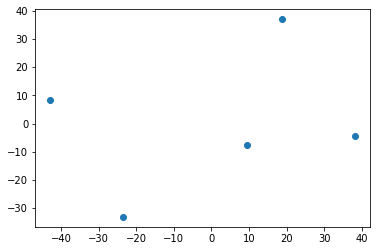

In [4]:
plot_result(cfg.cityCoordinat)

In [5]:
len(cfg.cityCoordinat)

5

In [6]:
cfg.weightData

[[0.0, 3.0, 4.0, 2.0, 7.0],
 [3.0, 0.0, 4.0, 6.0, 3.0],
 [4.0, 4.0, 0.0, 5.0, 8.0],
 [2.0, 6.0, 5.0, 0.0, 6.0],
 [7.0, 3.0, 8.0, 6.0, 0.0]]

In [7]:
#
# Individual.py
#
#

import math
import collections

#A simple 1-D Individual class
class Individual:
    """
    Individual
    """
    minSigma=1e-100
    maxSigma=1
    learningRate=None
    uniprng=None
    normprng=None
    fitFunc=None
    cityCoordinat=None
    startCity=None
    numberofCity=None
    weightdata=None
    populationSize=None
    var=None
    
        

    def __init__(self):
        self.x=CityPath()
        self.fit=self.__class__.fitFunc(self.x)
        self.sigma=self.uniprng.uniform(1/self.populationSize,1/self.numberofCity) #use "normalized" sigma
        
    def crossover(self, other):
        
        for a in range(0,len(self.x)):
            alpha=self.uniprng.uniform(0,1)
            probability=0.5
            
            if(alpha<probability):
                self.x[a], other.x[a] = other.x[a], self.x[a]
                dupli_x=self.list_duplicates(self.x)
                dupli_other=self.list_duplicates(other.x)
                
                if (len(dupli_x)!=0 and len(dupli_other)!=0 ):
                    self.x[dupli_x[0]], other.x[dupli_other[0]] = other.x[dupli_other[0]], self.x[dupli_x[0]]
        '''This is for 1 Point crossover
        #perform crossover "in-place"
        alpha=self.uniprng.randint(0,self.latticeLength-1)
        
        #Swap the list based on alpha
        self.x[alpha:], other.x[alpha:] = other.x[alpha:], self.x[alpha:]'''
        
        self.fit=None
        other.fit=None
        
    def list_duplicates(self,seq):
        seen = set()
        seen_add = seen.add
        return [idx for idx,item in enumerate(seq) if item in seen or seen_add(item)]

    
    def mutate(self):
        self.sigma=self.sigma*math.exp(self.learningRate*self.normprng.normalvariate(0,1))
        if self.sigma < 1/self.populationSize: 
            self.sigma=1/self.populationSize
        if self.sigma > 1/self.numberofCity: 
            self.sigma=1/self.numberofCity

        if self.uniprng.uniform(0,1)<self.sigma: #randomprobability of mutation
            if (self.startCity==0):
                mutationindex=self.uniprng.randint(0,self.numberofCity-1)
                self.x[mutationindex]=self.uniprng.randint(0,self.numberofCity-1)

            else:
                mutationindex=self.uniprng.randint(1,self.numberofCity-1)   
                self.x[mutationindex]=self.uniprng.randint(1,self.numberofCity-1)
            differ=self.diff(self.x)

            if len(differ)!=0:
                samevalindex=self.list_duplicates_of(self.x.x, self.x[mutationindex])
                samevalindex.remove(mutationindex)
                self.x[samevalindex[0]]=differ[0]
           
        self.fit=None
        
    def diff(self,second):
        first =set(list(range(0, self.numberofCity)))
        return [item for item in first if item not in second]    
        
    def list_duplicates_of(self,seq,item):
        start_at = -1
        locs = []
        while True:
            try:
                loc = seq.index(item,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        return locs

    def evaluateFitness(self):
        if self.fit == None: self.fit=self.__class__.fitFunc(self.x)
        
        
    def __repr__(self):
         return str(self.x)+'\t'+str(self.fit)+'\t'+str(self.sigma)

    
class CityPath(Individual):
    def __init__(self):
        if (self.startCity==0):
            self.x=self.uniprng.sample(range(self.numberofCity), self.numberofCity)
            
        else:
            x=self.uniprng.sample(range(self.startCity,self.numberofCity), self.numberofCity-self.startCity)
            y=self.uniprng.sample(range(0,self.startCity-1),self.startCity-1)
            z=[self.startCity-1]
            z.append(y)
            z.append(x)
            flatlist=self.flatten(z)
            copy = flatlist[1:]
            self.uniprng.shuffle(copy)
            flatlist[1:] = copy # overwrite the original
            self.x=flatlist
    
    def flatten(self,x):
        if isinstance(x, collections.Iterable):
            return [a for i in x for a in self.flatten(i)]
        else:
            return [x]
            

    def interactionCity(self):
        tempintercity=[]
        for a in range (0,len(self.x)):

            if(a==len(self.x)-1):
                tempintercity.append(self.weightdata[self.x[a]][self.x[0]])
            else:
                tempintercity.append(self.weightdata[self.x[a]][self.x[a+1]])
        return sum(tempintercity)

              
    def __repr__(self):
        return str(self.x)
    
    def __getitem__(self, key):
        return self.x[key]
    
    def __len__(self):
        return len(self.x)
    
    def __setitem__(self, key, value):
        self.x[key] = value

    


In [8]:
#
# Population.py
#
#

import copy
import math
from operator import attrgetter


class Population:
    """
    Population
    """
    uniprng=None
    crossoverFraction=None
    
    def __init__(self, populationSize):
        """
        Population constructor
        """
        self.population=[]
        for i in range(populationSize):
            self.population.append(Individual())                                                                                                                                        

    def __len__(self):
        return len(self.population)
    
    def __getitem__(self,key):
        return self.population[key]
    
    def __setitem__(self,key,newValue):
        self.population[key]=newValue
        
    def copy(self):
        return copy.deepcopy(self)
            
    def evaluateFitness(self):
        for individual in self.population: individual.evaluateFitness()
            
    def mutate(self):     
        for individual in self.population:
            individual.mutate()
            
    def crossover(self):
        if (self.startCity==0):
            indexList1=list(range(len(self)))
            indexList2=list(range(len(self)))
        else:
            indexList1=list(range(1,len(self)))
            indexList2=list(range(1,len(self)))
            
        self.uniprng.shuffle(indexList1)
        self.uniprng.shuffle(indexList2)

        if self.crossoverFraction == 1.0:             
            for index1,index2 in zip(indexList1,indexList2):
                self[index1].crossover(self[index2])
        else:
            for index1,index2 in zip(indexList1,indexList2):
                rn=self.uniprng.random()
                if rn < self.crossoverFraction:
                    self[index1].crossover(self[index2])        

            
    def conductTournament(self):
        # binary tournament
        indexList1=list(range(len(self)))
        indexList2=list(range(len(self)))
        
        self.uniprng.shuffle(indexList1)
        self.uniprng.shuffle(indexList2)
        
        # do not allow self competition
        for i in range(len(self)):
            if indexList1[i] == indexList2[i]:
                temp=indexList2[i]
                if i == 0:
                    indexList2[i]=indexList2[-1]
                    indexList2[-1]=temp
                else:
                    indexList2[i]=indexList2[i-1]
                    indexList2[i-1]=temp
        
        #compete
        newPop=[]        
        for index1,index2 in zip(indexList1,indexList2):
            if self[index1].fit < self[index2].fit:
                newPop.append(copy.deepcopy(self[index1]))
            elif self[index1].fit > self[index2].fit:
                newPop.append(copy.deepcopy(self[index2]))
            else:
                rn=self.uniprng.random()
                if rn > 0.5:
                    newPop.append(copy.deepcopy(self[index1]))
                else:
                    newPop.append(copy.deepcopy(self[index2]))
        
        # overwrite old pop with newPop    
        self.population=newPop        


    def combinePops(self,otherPop):
        self.population.extend(otherPop.population)

    def truncateSelect(self,newPopSize):
        #sort by fitness
        self.population.sort(key=attrgetter('fit'),reverse=False)
        
        #then truncate the bottom
        self.population=self.population[:newPopSize]  
                
    def __str__(self):
        s=''
        for ind in self:
            s+=str(ind) + '\n'
        return s




In [9]:
from random import Random

#start random number generators
uniprng=Random()
uniprng.seed(cfg.randomSeed)
normprng=Random()
normprng.seed(cfg.randomSeed+101)

#set static params on classes
# (probably not the most elegant approach, but let's keep things simple...)

Individual.fitFunc=fitnessFunc
Individual.uniprng=uniprng
Individual.normprng=normprng
Individual.populationSize=cfg.populationSize
Individual.cityCoordinat=cfg.cityCoordinat
Individual.startCity=cfg.startCity
Individual.numberofCity=len(cfg.weightData)
Individual.weightdata=cfg.weightData
Individual.learningRate=cfg.learningRate
Population.uniprng=uniprng
Population.crossoverFraction=cfg.crossoverFraction
Population.startCity=cfg.startCity


#create initial Population (random initialization)
population=Population(cfg.populationSize)




In [10]:
cfg.startCity

1

In [11]:
populationmax=Population(cfg.populationSize)


In [12]:
printStats(populationmax,0)

Generation: 0
[0, 1, 3, 4, 2]	27.0	0.12301829218412047
[0, 3, 4, 2, 1]	23.0	0.04430584593610018
[0, 4, 2, 1, 3]	27.0	0.14904481611973824
[0, 4, 1, 3, 2]	25.0	0.09434147895606941
[0, 2, 1, 4, 3]	19.0	0.1718621626439726
[0, 2, 1, 3, 4]	27.0	0.1958103504284735
[0, 1, 3, 4, 2]	27.0	0.1516928714341754
[0, 4, 2, 3, 1]	29.0	0.06600548681972188
[0, 2, 4, 1, 3]	23.0	0.1501854874661566
[0, 1, 3, 2, 4]	29.0	0.18875570937288425
[0, 2, 4, 3, 1]	27.0	0.09538981192085526
[0, 2, 1, 3, 4]	27.0	0.17253549610753544
[0, 3, 4, 1, 2]	19.0	0.17828098265843392
[0, 1, 2, 3, 4]	25.0	0.07396331521908327
[0, 3, 2, 4, 1]	21.0	0.19015687693832894
[0, 4, 3, 2, 1]	25.0	0.07746721897753504
[0, 3, 2, 4, 1]	21.0	0.12595141671168694
[0, 4, 3, 1, 2]	27.0	0.1802937674560904
[0, 1, 4, 2, 3]	21.0	0.09661800974125778
[0, 4, 3, 2, 1]	25.0	0.15587326375294874
[0, 1, 2, 3, 4]	25.0	0.11809685957045715
[0, 2, 3, 4, 1]	21.0	0.15384037676118775
[0, 3, 1, 2, 4]	27.0	0.1869291287957078
[0, 3, 2, 4, 1]	21.0	0.13723273145827025
[0, 2, 3

In [13]:
offspringmax=populationmax.copy()

In [14]:
offspringmax.population

[[0, 1, 3, 4, 2]	27.0	0.12301829218412047,
 [0, 3, 4, 2, 1]	23.0	0.04430584593610018,
 [0, 4, 2, 1, 3]	27.0	0.14904481611973824,
 [0, 4, 1, 3, 2]	25.0	0.09434147895606941,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 2, 1, 3, 4]	27.0	0.1958103504284735,
 [0, 1, 3, 4, 2]	27.0	0.1516928714341754,
 [0, 4, 2, 3, 1]	29.0	0.06600548681972188,
 [0, 2, 4, 1, 3]	23.0	0.1501854874661566,
 [0, 1, 3, 2, 4]	29.0	0.18875570937288425,
 [0, 2, 4, 3, 1]	27.0	0.09538981192085526,
 [0, 2, 1, 3, 4]	27.0	0.17253549610753544,
 [0, 3, 4, 1, 2]	19.0	0.17828098265843392,
 [0, 1, 2, 3, 4]	25.0	0.07396331521908327,
 [0, 3, 2, 4, 1]	21.0	0.19015687693832894,
 [0, 4, 3, 2, 1]	25.0	0.07746721897753504,
 [0, 3, 2, 4, 1]	21.0	0.12595141671168694,
 [0, 4, 3, 1, 2]	27.0	0.1802937674560904,
 [0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 4, 3, 2, 1]	25.0	0.15587326375294874,
 [0, 1, 2, 3, 4]	25.0	0.11809685957045715,
 [0, 2, 3, 4, 1]	21.0	0.15384037676118775,
 [0, 3, 1, 2, 4]	27.0	0.1869291287957078,
 [0, 3, 2, 4, 1]	

In [15]:
offspringmax.conductTournament()

In [16]:
offspringmax.population

[[0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 1, 3, 4, 2]	27.0	0.12301829218412047,
 [0, 2, 3, 4, 1]	21.0	0.0653047597060568,
 [0, 2, 1, 3, 4]	27.0	0.1958103504284735,
 [0, 3, 2, 4, 1]	21.0	0.19015687693832894,
 [0, 4, 3, 2, 1]	25.0	0.07746721897753504,
 [0, 3, 4, 2, 1]	23.0	0.04430584593610018,
 [0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 3, 4, 1, 2]	19.0	0.17828098265843392,
 [0, 4, 2, 1, 3]	27.0	0.14904481611973824,
 [0, 4, 3, 1, 2]	27.0	0.1802937674560904,
 [0, 2, 3, 4, 1]	21.0	0.15384037676118775,
 [0, 3, 4, 1, 2]	19.0	0.17828098265843392,
 [0, 3, 1, 2, 4]	27.0	0.1869291287957078,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 3, 2, 4, 1]	21.0	0.12595141671168694,
 [0, 3, 2, 4, 1]	21.0	0.13723273145827025,
 [0, 3, 2, 4, 1]	21.0	0.12595141671168694,
 [0, 2, 4, 1, 3]	23.0	0.1501854874661566,
 [0, 3, 2, 4, 1]	21.0	0.19015687693832894,
 [0, 2, 3, 4, 1]	21.0	0.0653047597060568,
 [0, 4, 1, 3, 2]	25.0	0.09434147895606941,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 2, 4, 3, 1]	27

In [17]:
offspringmax.crossover()

In [18]:
offspringmax.population

[[0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 1, 3, 4, 2]	27.0	0.12301829218412047,
 [0, 4, 3, 1, 2]	None	0.0653047597060568,
 [0, 3, 1, 4, 2]	None	0.1958103504284735,
 [0, 3, 2, 4, 1]	None	0.19015687693832894,
 [0, 4, 3, 1, 2]	None	0.07746721897753504,
 [0, 2, 4, 1, 3]	None	0.04430584593610018,
 [0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 2, 3, 1, 4]	None	0.17828098265843392,
 [0, 4, 2, 1, 3]	27.0	0.14904481611973824,
 [0, 3, 4, 1, 2]	None	0.1802937674560904,
 [0, 2, 3, 4, 1]	None	0.15384037676118775,
 [0, 3, 4, 2, 1]	None	0.17828098265843392,
 [0, 3, 1, 2, 4]	27.0	0.1869291287957078,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 3, 2, 4, 1]	None	0.12595141671168694,
 [0, 3, 2, 4, 1]	21.0	0.13723273145827025,
 [0, 3, 2, 4, 1]	None	0.12595141671168694,
 [0, 3, 4, 1, 2]	None	0.1501854874661566,
 [0, 2, 3, 4, 1]	None	0.19015687693832894,
 [0, 2, 3, 4, 1]	21.0	0.0653047597060568,
 [0, 4, 1, 3, 2]	25.0	0.09434147895606941,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 2, 4, 3, 1]	27

In [19]:
offspringmax.mutate()


In [20]:
offspringmax.population

[[0, 1, 4, 2, 3]	None	0.2,
 [0, 1, 3, 4, 2]	None	0.04387786394461249,
 [0, 4, 3, 1, 2]	None	0.12426994135214577,
 [0, 3, 1, 4, 2]	None	0.16056339977233203,
 [0, 3, 2, 4, 1]	None	0.04,
 [0, 4, 3, 1, 2]	None	0.04,
 [0, 2, 4, 1, 3]	None	0.04,
 [0, 4, 1, 2, 3]	None	0.04,
 [0, 2, 3, 1, 4]	None	0.2,
 [0, 4, 1, 2, 3]	None	0.04,
 [0, 3, 4, 1, 2]	None	0.2,
 [0, 2, 3, 4, 1]	None	0.04,
 [0, 3, 4, 2, 1]	None	0.2,
 [0, 3, 1, 2, 4]	None	0.04,
 [0, 2, 1, 4, 3]	None	0.2,
 [0, 3, 2, 4, 1]	None	0.15226814830913163,
 [0, 3, 2, 4, 1]	None	0.2,
 [0, 3, 2, 4, 1]	None	0.04,
 [0, 3, 4, 1, 2]	None	0.04,
 [0, 2, 3, 4, 1]	None	0.2,
 [0, 2, 4, 3, 1]	None	0.13886990094961432,
 [0, 4, 1, 3, 2]	None	0.2,
 [0, 2, 1, 4, 3]	None	0.09252288618301584,
 [0, 2, 4, 3, 1]	None	0.2,
 [0, 2, 3, 4, 1]	None	0.2]

In [21]:
offspringmax.evaluateFitness()        


In [22]:
offspringmax.population

[[0, 1, 4, 2, 3]	21.0	0.2,
 [0, 1, 3, 4, 2]	27.0	0.04387786394461249,
 [0, 4, 3, 1, 2]	27.0	0.12426994135214577,
 [0, 3, 1, 4, 2]	23.0	0.16056339977233203,
 [0, 3, 2, 4, 1]	21.0	0.04,
 [0, 4, 3, 1, 2]	27.0	0.04,
 [0, 2, 4, 1, 3]	23.0	0.04,
 [0, 4, 1, 2, 3]	21.0	0.04,
 [0, 2, 3, 1, 4]	25.0	0.2,
 [0, 4, 1, 2, 3]	21.0	0.04,
 [0, 3, 4, 1, 2]	19.0	0.2,
 [0, 2, 3, 4, 1]	21.0	0.04,
 [0, 3, 4, 2, 1]	23.0	0.2,
 [0, 3, 1, 2, 4]	27.0	0.04,
 [0, 2, 1, 4, 3]	19.0	0.2,
 [0, 3, 2, 4, 1]	21.0	0.15226814830913163,
 [0, 3, 2, 4, 1]	21.0	0.2,
 [0, 3, 2, 4, 1]	21.0	0.04,
 [0, 3, 4, 1, 2]	19.0	0.04,
 [0, 2, 3, 4, 1]	21.0	0.2,
 [0, 2, 4, 3, 1]	27.0	0.13886990094961432,
 [0, 4, 1, 3, 2]	25.0	0.2,
 [0, 2, 1, 4, 3]	19.0	0.09252288618301584,
 [0, 2, 4, 3, 1]	27.0	0.2,
 [0, 2, 3, 4, 1]	21.0	0.2]

In [23]:
populationmax.combinePops(offspringmax)


In [24]:
populationmax.population

[[0, 1, 3, 4, 2]	27.0	0.12301829218412047,
 [0, 3, 4, 2, 1]	23.0	0.04430584593610018,
 [0, 4, 2, 1, 3]	27.0	0.14904481611973824,
 [0, 4, 1, 3, 2]	25.0	0.09434147895606941,
 [0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 2, 1, 3, 4]	27.0	0.1958103504284735,
 [0, 1, 3, 4, 2]	27.0	0.1516928714341754,
 [0, 4, 2, 3, 1]	29.0	0.06600548681972188,
 [0, 2, 4, 1, 3]	23.0	0.1501854874661566,
 [0, 1, 3, 2, 4]	29.0	0.18875570937288425,
 [0, 2, 4, 3, 1]	27.0	0.09538981192085526,
 [0, 2, 1, 3, 4]	27.0	0.17253549610753544,
 [0, 3, 4, 1, 2]	19.0	0.17828098265843392,
 [0, 1, 2, 3, 4]	25.0	0.07396331521908327,
 [0, 3, 2, 4, 1]	21.0	0.19015687693832894,
 [0, 4, 3, 2, 1]	25.0	0.07746721897753504,
 [0, 3, 2, 4, 1]	21.0	0.12595141671168694,
 [0, 4, 3, 1, 2]	27.0	0.1802937674560904,
 [0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 4, 3, 2, 1]	25.0	0.15587326375294874,
 [0, 1, 2, 3, 4]	25.0	0.11809685957045715,
 [0, 2, 3, 4, 1]	21.0	0.15384037676118775,
 [0, 3, 1, 2, 4]	27.0	0.1869291287957078,
 [0, 3, 2, 4, 1]	

In [25]:
populationmax.truncateSelect(20)


In [26]:
populationmax.population

[[0, 2, 1, 4, 3]	19.0	0.1718621626439726,
 [0, 3, 4, 1, 2]	19.0	0.17828098265843392,
 [0, 3, 4, 1, 2]	19.0	0.2,
 [0, 2, 1, 4, 3]	19.0	0.2,
 [0, 3, 4, 1, 2]	19.0	0.04,
 [0, 2, 1, 4, 3]	19.0	0.09252288618301584,
 [0, 3, 2, 4, 1]	21.0	0.19015687693832894,
 [0, 3, 2, 4, 1]	21.0	0.12595141671168694,
 [0, 1, 4, 2, 3]	21.0	0.09661800974125778,
 [0, 2, 3, 4, 1]	21.0	0.15384037676118775,
 [0, 3, 2, 4, 1]	21.0	0.13723273145827025,
 [0, 2, 3, 4, 1]	21.0	0.0653047597060568,
 [0, 1, 4, 2, 3]	21.0	0.2,
 [0, 3, 2, 4, 1]	21.0	0.04,
 [0, 4, 1, 2, 3]	21.0	0.04,
 [0, 4, 1, 2, 3]	21.0	0.04,
 [0, 2, 3, 4, 1]	21.0	0.04,
 [0, 3, 2, 4, 1]	21.0	0.15226814830913163,
 [0, 3, 2, 4, 1]	21.0	0.2,
 [0, 3, 2, 4, 1]	21.0	0.04]

In [28]:
printStats(populationmax,1)

Generation: 1
[0, 2, 1, 4, 3]	19.0	0.1718621626439726
[0, 3, 4, 1, 2]	19.0	0.17828098265843392
[0, 3, 4, 1, 2]	19.0	0.2
[0, 2, 1, 4, 3]	19.0	0.2
[0, 3, 4, 1, 2]	19.0	0.04
[0, 2, 1, 4, 3]	19.0	0.09252288618301584
[0, 3, 2, 4, 1]	21.0	0.19015687693832894
[0, 3, 2, 4, 1]	21.0	0.12595141671168694
[0, 1, 4, 2, 3]	21.0	0.09661800974125778
[0, 2, 3, 4, 1]	21.0	0.15384037676118775
[0, 3, 2, 4, 1]	21.0	0.13723273145827025
[0, 2, 3, 4, 1]	21.0	0.0653047597060568
[0, 1, 4, 2, 3]	21.0	0.2
[0, 3, 2, 4, 1]	21.0	0.04
[0, 4, 1, 2, 3]	21.0	0.04
[0, 4, 1, 2, 3]	21.0	0.04
[0, 2, 3, 4, 1]	21.0	0.04
[0, 3, 2, 4, 1]	21.0	0.15226814830913163
[0, 3, 2, 4, 1]	21.0	0.2
[0, 3, 2, 4, 1]	21.0	0.04
Min fitness 19.0
Sigma 0.1718621626439726
Avg fitness 20.4



In [69]:
def fitnessFuncPlot(fitdata):
    plt.plot(*zip(*fitdata), 'o')



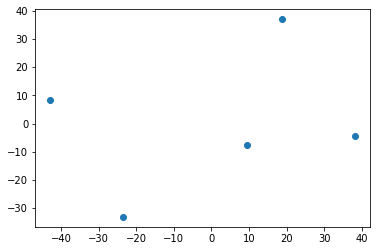

In [73]:
fitnessFuncPlot(cfg.cityCoordinat)

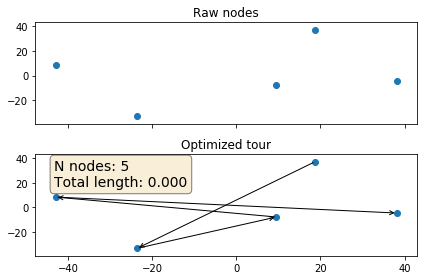

In [109]:
import matplotlib.pyplot as plt

positions=np.array(cfg.cityCoordinat)
N=5
x_sol=[[1,0,0,0,0],
       [0,0,1,0,0],
       [0,1,0,0,0],
       [0,0,0,0,1],
       [0,0,0,1,0]]


fig, ax = plt.subplots(2, sharex=True, sharey=True)         # Prepare 2 plots
ax[0].set_title("Raw nodes")
ax[1].set_title("Optimized tour")
ax[0].scatter(positions[:, 0], positions[:, 1])             # plot A
ax[1].scatter(positions[:, 0], positions[:, 1])             # plot B
start_node = 0
distance = 0.
for i in range(N):
    start_pos = positions[start_node]
    next_node = np.argmax(x_sol[i]) # needed because of MIP-approach used for TSP
    end_pos = positions[next_node]
    ax[1].annotate("",
            xy=start_pos, xycoords='data',
            xytext=end_pos, textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
    start_node = next_node

textstr = "N nodes: %d\nTotal length: %.3f" % (N, distance)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=14, # Textbox
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [132]:
cfg.cityCoordinat=[[-0.000000   ,-0.000000],
 [-3.818204  ,  0.000000],
 [ -1.149491  ,  3.347706],
 [1.107833  , -1.629565],
 [-5.317544 ,  -3.189793]]

In [72]:
*zip(*cfg.cityCoordinat)

SyntaxError: can't use starred expression here (<ipython-input-72-b40132d9ab48>, line 4)

In [116]:
points

[(1, 1), (8, 2), (4, 3), (9, 4), (2, 9), (1, 5), (8, 7)]

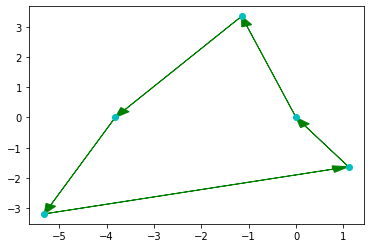

In [140]:
import matplotlib.pyplot as plt

def plotTSP(path, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    
    """

    # Unpack the primary TSP path and transform it into a list of ordered 
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])
    
    plt.plot(x, y, 'co')

    a_scale = float(max(x))/float(5)
    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale, 
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
#     plt.xlim(0, max(x)*1.1)
#     plt.ylim(0, max(y)*1.1)
    plt.show()


if __name__ == '__main__':
    res = [tuple(i) for i in cfg.cityCoordinat]
    # Local Search operation
    path1 = [0, 2, 1, 4, 3]

    # Pack the paths into a list
    paths = [path1]
    
    # Run the function
    plotTSP(paths, res, 1)

In [133]:
res = [tuple(i) for i in cfg.cityCoordinat]

In [129]:
res

[(38.11859274, -4.55047759),
 (9.53610599, -7.76596505),
 (-42.82924297, 8.39593469),
 (18.69724157, 37.10607754),
 (-23.52269734, -33.18556959)]